### Import CIFAR-10 Data

In [1]:
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import time

- load **images data** and **labels** from files

In [2]:
def load_CIFAR10_batch(filename):
    with open(filename, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')

        x = dict[b'data']
        y = dict[b'labels']
        y = np.array(y)
    return x, y

### Merge Traing Data

- using *load_CIFAR10_batch* load files
- np.append & np.concatenate 

In [3]:
def load_data():
    xs = []
    ys = []
    for i in range(1, 6):
        filename = './cifar-10-batches-py/data_batch_' + str(i)
        X, Y = load_CIFAR10_batch(filename)
        xs.append(X)
        ys.append(Y)

    x_train = np.concatenate(xs)
    y_train = np.concatenate(ys)
    del xs, ys
    x_test, y_test = load_CIFAR10_batch('./cifar-10-batches-py/test_batch')

    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
    'ship', 'truck']

    # Normalize Data
#     mean_image = np.mean(x_train, axis=0)
#     x_train -= mean_image
#     x_test -= mean_image

    data_dict = {
        'images_train': x_train,
        'labels_train': y_train,
        'images_test': x_test,
        'labels_test': y_test,
        'classes': classes
    }
    return data_dict

### Reshape Data
 *data_dict = load_data()*
- reshape [-1, 3072] to [-1, 3, 32, 32]
- transpoes [-1, 32, 32, 3]


In [4]:
def reshape_data(data_dict):
    im_tr = np.array(data_dict['images_train'])
    im_tr = np.reshape(im_tr, (-1, 3, 32, 32))
    im_tr = np.transpose(im_tr, (0,2,3,1))
    data_dict['images_train'] = im_tr
    im_te = np.array(data_dict['images_test'])
    im_te = np.reshape(im_te, (-1, 3, 32, 32))
    im_te = np.transpose(im_te, (0,2,3,1))
    data_dict['images_test'] = im_te
    return data_dict

### Generate Batch
 data = reshape_data(load_data())
- yield is a keyword that is used like return, except the function will return a generator.
    > **Python Code** 
```
    >>> def createGenerator():
    ...    mylist = range(3)
    ...    for i in mylist:
    ...        yield i*i
    ...
    >>> mygenerator = createGenerator() # create a generator
    >>> print(mygenerator) # mygenerator is an object!
 <generator object createGenerator at 0xb7555c34>
    >>> for i in mygenerator:
    ...     print(i)
    0
    1
    4
```

In [5]:
def gen_batch(data, batch_size, num_iter):
    data = np.array(data)
    index = len(data)
    for i in range(num_iter):
        index += batch_size
        if (index + batch_size > len(data)):
            index = 0
            shuffled_indices = np.random.permutation(np.arange(len(data)))
            data = data[shuffled_indices]
        yield data[index:index + batch_size]

In [6]:
def main():
    data_sets = load_data()
    print(data_sets['images_train'].shape)
    print(data_sets['labels_train'].shape)
    print(data_sets['images_test'].shape)
    print(data_sets['labels_test'].shape)

In [7]:
data_reshape = reshape_data(load_data())

train_X = data_reshape['images_train']
train_Y = data_reshape['labels_train']
test_X = data_reshape['images_test']
test_Y = data_reshape['labels_test']
classes = load_data()['classes']

In [8]:
X = tf.placeholder(shape=[None, 32, 32, 3], dtype=tf.float32, name='X')
Y = tf.placeholder(shape=[None], dtype=tf.uint8, name='Y')
W = tf.Variable(tf.zeros([3072, 10]), name='W')
B = tf.Variable(tf.zeros([10]), name='B')

In [9]:
def layer(input, weight_shape, name):
    with tf.name_scope(name):
        W = tf.Variable(tf.truncated_normal(shape=weight_shape, mean=0.0, stddev=0.02, name='layer_W'))
        L = tf.nn.conv2d(input, W, strides=[1,1,1,1], padding='SAME', name='conv')
        relu = tf.nn.relu(L, name='relu')
        return W, relu

In [10]:
def fully_connect(input, weight_shape, bias_shape, name):
    with tf.name_scope(name):
        W = tf.get_variable('lay_W', shape=weight_shape, initializer=tf.contrib.layers.xavier_initializer())
        B = tf.Variable(tf.zeros(bias_shape), name='ful_B')
        H = tf.matmul(input, W, name='ful_H') + B
        softmax = tf.nn.softmax(H, name='softmaxw')
        return H, softmax

In [11]:
## Layer 1 => 0-W, 1-B, 2-W, 3-output
layer_1 = layer(X, [2, 2, 3, 32], 'first')[1]
layer_2 = layer(layer_1, [2, 2, 32, 64], 'second')[1]
pool_1 = tf.nn.max_pool(layer_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pooling')

layer_3 = layer(pool_1, [2, 2, 64, 128], 'third')[1]
layer_4 = layer(layer_3, [2, 2, 128, 128], 'forth')[1]
pool_2 = tf.nn.max_pool(layer_4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pooling')

# reshape Last output to vector
vec_layer = tf.reshape(pool_2, [-1, 8*8*128])

In [12]:
## fully connect => 0-output, 1-sofrmax
ful_output, softmax = fully_connect(vec_layer, [8*8*128, 10], [10], 'last')

In [13]:
## one_hot label
Y_one = tf.one_hot(Y, 10, axis=1)
## predict 

In [14]:
## minimize
entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y_one, logits=ful_output, name='loss')
loss = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

In [15]:
# Accuracy
Accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(softmax, 1), tf.argmax(Y_one, 1)), dtype=tf.float32))

epoch : 0
loss ==>  33.5001102686
epoch : 1
loss ==>  28.9709374905
epoch : 2
loss ==>  25.5707489252
epoch : 3
loss ==>  23.9284497499
epoch : 4
loss ==>  22.5502748489
epoch : 5
loss ==>  21.5335057974
epoch : 6
loss ==>  20.7347689867
epoch : 7
loss ==>  19.1100748777
epoch : 8
loss ==>  17.9092431068
epoch : 9
loss ==>  16.9098742008
epoch : 10
loss ==>  16.314652741
epoch : 11
loss ==>  15.3973989487
epoch : 12
loss ==>  14.935230732
epoch : 13
loss ==>  14.4103632569
epoch : 14
loss ==>  13.8300413489
epoch : 15
loss ==>  13.3736076951
epoch : 16
loss ==>  12.8069419265
epoch : 17
loss ==>  12.5877433419
epoch : 18
loss ==>  12.3692137599
epoch : 19
loss ==>  12.0192501545
epoch : 20
loss ==>  11.4973922968
epoch : 21
loss ==>  11.0445728898
epoch : 22
loss ==>  10.6257932782
epoch : 23
loss ==>  10.2207852006
epoch : 24
loss ==>  9.97921735048
epoch : 25
loss ==>  9.84368246794
epoch : 26
loss ==>  9.88002389669
epoch : 27
loss ==>  9.86976611614
epoch : 28
loss ==>  9.563577413

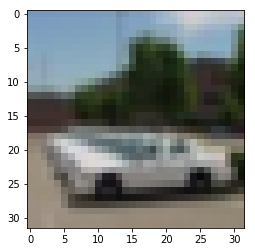

car === car


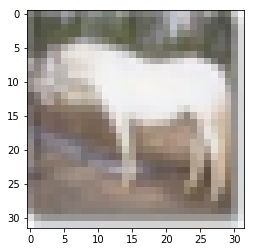

horse === horse


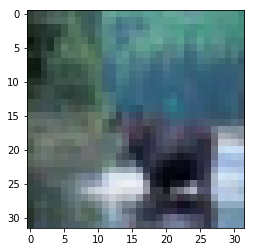

deer === deer


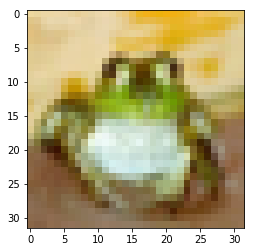

frog === frog


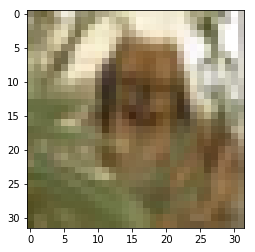

dog === dog


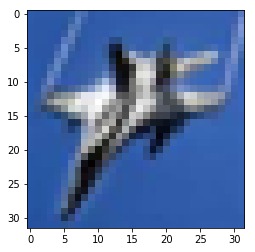

plane === plane


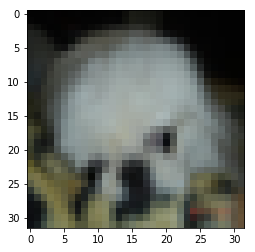

dog === dog


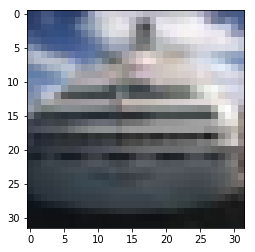

ship === ship


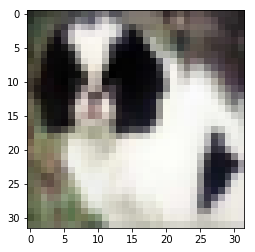

dog === dog


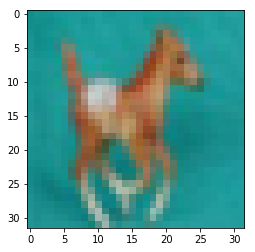

horse === horse


In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epoch = 30
    batch_size_train = 3000
    batch_count_train = 50000 // batch_size_train
    for i in range(epoch):
        print("epoch :", i)
        loss_total=0
        for i in range(batch_count_train):
            batch_index_train = i*batch_size_train
            img = train_X[batch_index_train:batch_index_train+batch_size_train]
            label = train_Y[batch_index_train:batch_index_train+batch_size_train]
            _,loss_val = sess.run([train_op, loss],feed_dict={X:img, Y:label})
            loss_total += loss_val
        print("loss ==> ", loss_total)
    
    
    batch_size_test = 100
    batch_count_test = 10000 // batch_size_test
    accur = []
    predic = []
    Y_onehot = []
    for i in range(batch_count_test):
        batch_index_test = i*batch_size_test
        test_img_1 = test_X[batch_index_test:batch_index_test+batch_size_test]
        test_label_1 = test_Y[batch_index_test:batch_index_test+batch_size_test]
        acc, pre, Y_ = sess.run([Accuracy, softmax, Y_one], feed_dict={X:test_img_1, Y:test_label_1})
        accur.append(acc)
        predic.append(pre)
        Y_onehot.append(Y_)
    print("Accuracy : ", np.mean(accur)) 
    num = np.random.uniform(0, 10000, 10).astype(int)
    test_img = test_X[:,:,:]
    predic = np.reshape(predic, [10000,10])
    Y_onehot = np.reshape(Y_onehot, [10000,10])
    for i in range(10):
        plt.imshow(test_img[num[i]])
        plt.show()
        print(classes[np.argmax(Y_onehot[num[i]])],"===",classes[np.argmax(predic[num[i]])])
#     print(test_img.dtype)
#     print(test_label.shape)
#     num = np.random.uniform(0, 10000, 10).astype(int)
#     img = test_img[num[i]]
#     print
#     plt.imshow(img)
#     plt.show()

In [ ]:
classes

In [ ]:
np.shape(Y_onehot)